In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
import torch
import matplotlib as mpl
import numpy as np
import seaborn as sns
import chnet.cahn_hill as ch
import matplotlib.pyplot as plt
from ipywidgets import interact
from toolz.curried import pipe, curry
from pymks.bases import LegendreBasis
from pymks import MKSLocalizationModel
warnings.filterwarnings('ignore')

In [3]:
def draw_im(im, title=None):
    im = np.squeeze(im)
    plt.imshow(im)
    plt.colorbar()
    if title is not None:
        plt.title(title)
    plt.show()
    
def draw_by_side(x, y, z, e):
    fig, axs = plt.subplots(1, 3, figsize=(16,5))
    fig.suptitle("Error : {:1.4f}".format(e), fontsize=14)
    im0 = axs[0].imshow(x)
    plt.colorbar(im0,ax=axs[0])
    im1 = axs[1].imshow(y)
    plt.colorbar(im1,ax=axs[1])
    im2 = axs[2].imshow(z)
    plt.colorbar(im2,ax=axs[2])
    axs[0].set_title("inp")
    axs[1].set_title("sim")
    axs[2].set_title("cnn")
#     cax,kw = mpl.colorbar.make_axes([ax for ax in axs.flat])
#     plt.colorbar(im, cax=cax, shrink=0.8, **kw)
    plt.show()

In [4]:
def rmserror(x, y):
    return np.sqrt(np.mean((x - y)**2))

def maerror(x, y):
    return np.mean(np.fabs((x - y)))

In [5]:
@curry
def return_slice(x_data, cutoff):
    if cutoff is not None:
        return pipe(x_data,
                    lambda x_data: np.asarray(x_data.shape).astype(int) // 2,
                    lambda new_shape: [slice(new_shape[idim]-cutoff,
                                             new_shape[idim]+cutoff+1)
                                       for idim in range(x_data.ndim)],
                    lambda slices: x_data[slices])
    else:
        return x_data
    
cropper = return_slice(cutoff=7)

# def init_unif(nsamples, dim_x, dim_y, seed=354875):
#     np.random.seed(seed)
#     return np.random.uniform(-0.95, 0.95, size=(nsamples, dim_x, dim_y))


# def init_norm(nsamples, dim_x, dim_y, seed=354875):
#     np.random.seed(seed)
#     means  = np.random.uniform(-0.1, 0.1, size=nsamples)
#     scales  = np.random.uniform(0.1, 0.5, size=nsamples)
    
#     x_data = [np.random.normal(loc=m, scale=s, size = (1, dim_x, dim_y)) for m,s in zip(means, scales)]
#     x_data = np.concatenate(x_data, axis=0)
    
#     np.clip(x_data, -0.95, 0.95, out=x_data)
    
#     return x_data

def init_unif(nsamples, dim_x, dim_y, seed=354875):
    np.random.seed(seed)
    return np.random.uniform(-0.98, 0.98, size=(nsamples, dim_x, dim_y))


def init_norm(nsamples, dim_x, dim_y, seed=354875):
    np.random.seed(seed)
    means  = np.random.uniform(-0.7, 0.7, size=nsamples)
    np.random.seed(seed)
    scales  = np.random.uniform(0.1, 0.5, size=nsamples)
    
    x_data = [np.random.normal(loc=m, 
                               scale=s, 
                               size = (1, dim_x, dim_y)) for m,s in zip(means, scales)]
    x_data = np.concatenate(x_data, axis=0)
    
    np.clip(x_data, -0.95, 0.95, out=x_data)
    
    return x_data

## Generate Data

In [6]:
@curry
def data_generator(nsamples=128, 
                   dim_x=64, 
                   init_steps=100, 
                   delta_sim_steps = 500,
                   dx = 0.25, 
                   dt = 0.01,
                   gamma=1.0, 
                   seed = None,
                   device = torch.device("cuda:0")):
    
    init_data1 = init_unif(nsamples//2, dim_x, dim_x, seed=seed)
    init_data2 = init_norm(nsamples//2, dim_x, dim_x, seed=seed)
    init_data = np.concatenate([init_data1, init_data2], axis=0)
    
    x_data = ch.ch_run_torch(init_data, dt=dt, gamma=gamma, 
                             dx=dx, sim_step=init_steps, device=device)
    y_data = ch.ch_run_torch(x_data, dt=dt, gamma=gamma, 
                             dx=dx, sim_step=delta_sim_steps, device=device)
    return x_data, y_data

In [8]:
%%time
x_data, y_data = data_generator(nsamples=4, dim_x=64, 
                                init_steps=10, 
                                delta_sim_steps = 500,
                                dx = 0.25, 
                                dt = 0.01,
                                gamma=1.0, 
                                seed = None,
                                device = torch.device("cuda:0"))

CPU times: user 2.23 s, sys: 907 ms, total: 3.14 s
Wall time: 3.19 s


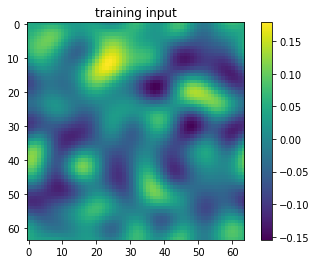

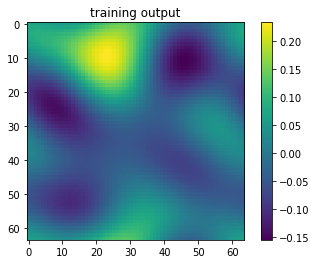

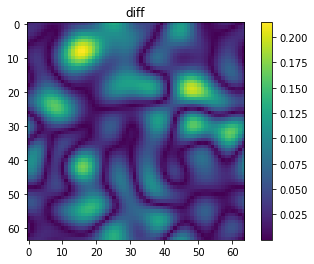

In [9]:
draw_im(x_data[0], "training input")
draw_im(y_data[0], "training output")

draw_im(np.fabs(x_data[0]-y_data[0]), "diff")

# or load saved microstructures from disk...

In [14]:
# nsamples = 1000
# x_data = np.load("data/unif/ch_5000_gamma_1000_dt_10_dx_250_101_unif.npy")[:nsamples]
# y_data = np.load("data/unif/ch_5100_gamma_1000_dt_10_dx_250_101_unif.npy")[:nsamples]

# x_val = np.load("data/unif/ch_5000_gamma_1000_dt_10_dx_250_101_unif.npy")[-nsamples:]
# y_val = np.load("data/unif/ch_5100_gamma_1000_dt_10_dx_250_101_unif.npy")[-nsamples:]

In [14]:
## Process Parameters
dim_x=64
init_steps=1
delta_sim_steps = 2500
dx = 0.25 
dt = 0.01
gamma=1.0

seed_trn = 110364
seed_val = 986423
# seed_prd = 284296
seed_prd = 487355


trn_size = 10
n_samples_trn = 1024*trn_size
n_samples_val = 512

init_features=32

In [15]:
%%time
x_trn, y_trn = data_generator(nsamples=n_samples_trn, 
                              dim_x=dim_x, 
                                init_steps=init_steps, 
                                delta_sim_steps = delta_sim_steps,
                                dx = dx, 
                                dt = dt,
                                gamma=gamma, 
                                seed =seed_trn,
                                device = torch.device("cuda:0"))

CPU times: user 23.3 s, sys: 22.3 s, total: 45.6 s
Wall time: 45 s


In [16]:
x_val, y_val = data_generator(nsamples=n_samples_val, 
                              dim_x=dim_x, 
                                init_steps=init_steps, 
                                delta_sim_steps = delta_sim_steps,
                                dx = dx, 
                                dt = dt,
                                gamma=gamma, 
                                seed =seed_prd*3,
                                device = torch.device("cuda:0"))

In [19]:
n_states = 11
domain = (-1.1, 1.1)
basis = LegendreBasis(n_states, domain)
model = MKSLocalizationModel(basis)

In [20]:
%%time
model.fit(x_trn, y_trn)

CPU times: user 1min 12s, sys: 22.3 s, total: 1min 35s
Wall time: 32.6 s


In [21]:
%%time
y_mks = model.predict(x_val)

CPU times: user 4.66 s, sys: 1.23 s, total: 5.88 s
Wall time: 1.6 s


In [29]:
maerror(y_val, y_mks)

0.17905197155316283

Pred vs Trgt: 0.179
benchmark: 0.409


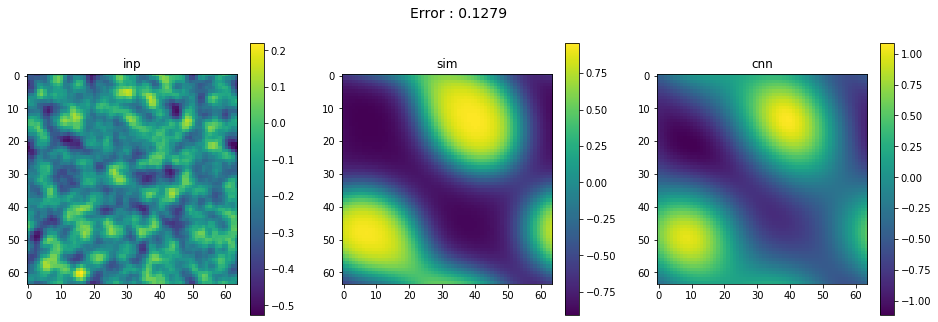

In [22]:
print("Pred vs Trgt: {:1.3f}".format(maerror(y_mks, y_val)))
print("benchmark: {:1.3f}".format(maerror(y_mks, x_val)))

draw_by_side(x_val[0], y_val[0], y_mks[0], maerror(y_val[0], y_mks[0]))

# If we 

In [18]:
coeff = model.coef_
@interact
def draw(i = (0,n_states-1)):
#     plt.imshow(cropper(coeff[:,:,i]))
    plt.imshow(coeff[:,:,i])
    plt.colorbar()
    plt.show()

interactive(children=(IntSlider(value=5, description='i', max=10), Output()), _dom_classes=('widget-interact',…

## Predicting future timesteps using same kernels

In [43]:
%%time
steps = 10
y_pred = x_val.copy()
print(0, y_pred.shape, rmserror(y_pred, y_val))
for step in range(steps):
    try:
        y_pred = model.predict(y_pred)
        print(step+1, y_pred.shape, rmserror(y_pred, y_val))
    except Exception as err:
        print(step, err)
        break

0 (512, 64, 64) 0.4776808328284706
1 (512, 64, 64) 0.19590114677962212
1 X must be within the specified domain
CPU times: user 4.67 s, sys: 1.17 s, total: 5.85 s
Wall time: 1.59 s


# Comparision with unet-leg model

In [30]:
from torch.utils.data import Dataset, DataLoader
from chnet.ch_loader import CahnHillDataset

In [31]:
from chnet.unet import UNet
model = UNet(in_channels=7, 
             out_channels=1, 
             init_features=init_features).double().to(torch.device("cuda:0"))
model.load_state_dict(torch.load("out/unet/ch_unet_id_14-04-2020-01-19_run_leg_7_data_30_longrun/unet_epoch_49.pt"))

<All keys matched successfully>

In [32]:
n_states = 7
domain = (-1.01, 1.01)
basis = LegendreBasis(n_states, domain)
transformer_x = lambda x: np.moveaxis(basis.discretize(x), 3, 1)
x_cuda = torch.tensor(transformer_x(x_val)).double().cuda()


model.eval()
y_cnn = np.squeeze(model(x_cuda).detach().cpu().numpy())
print(maerror(y_cnn, y_val))

0.04240991963932318


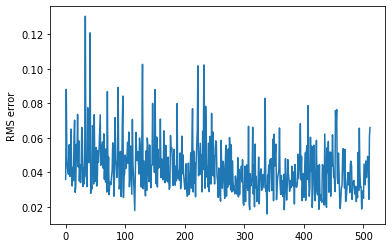

Mean Error on Validation Set: 0.0424


In [33]:
err = []
for ix in range(len(y_cnn)):
    err.append(maerror(y_cnn[ix], y_val[ix]))

plt.plot(np.arange(len(y_cnn)), err)
plt.ylabel("RMS error")
plt.show()

print("Mean Error on Validation Set: {:1.4f}".format(np.mean(err)))

top 5 worst case :


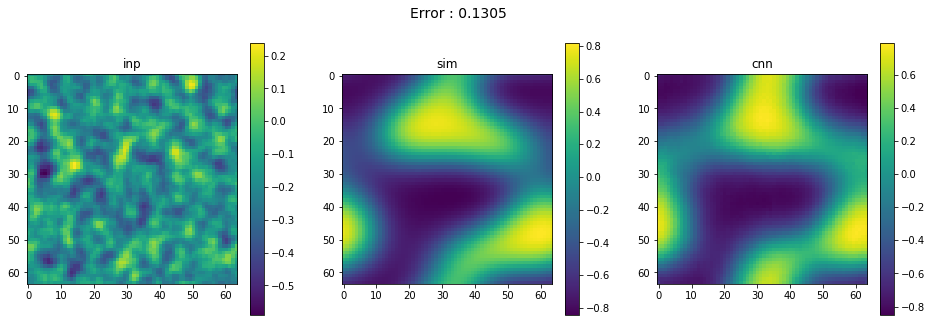

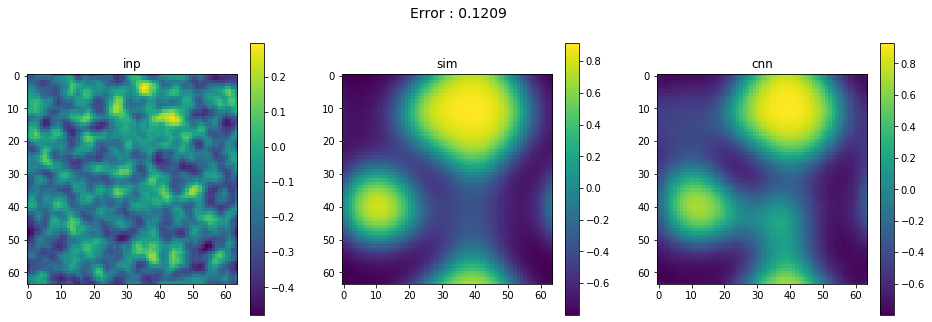

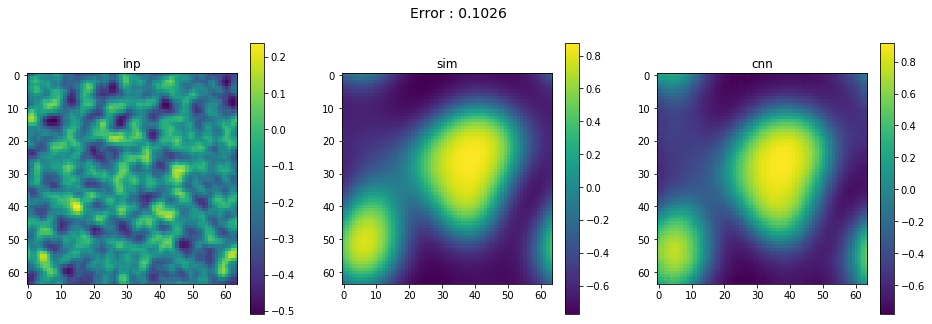

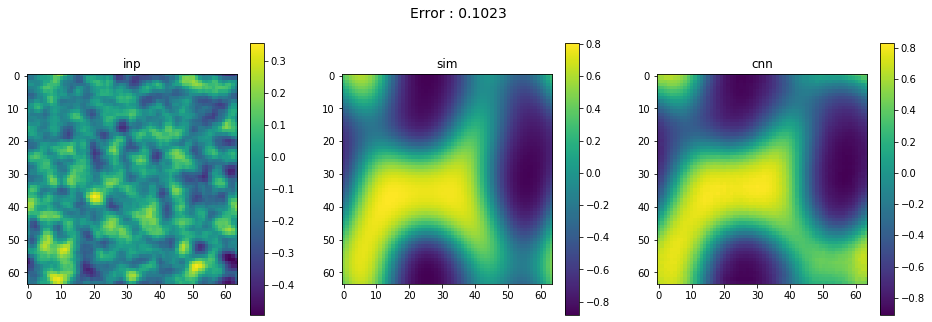

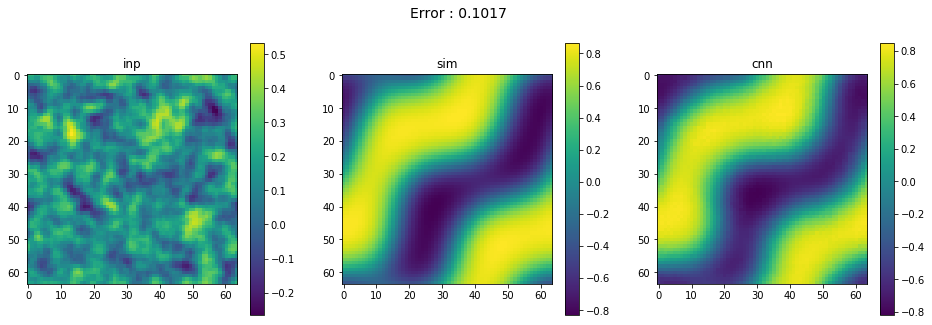

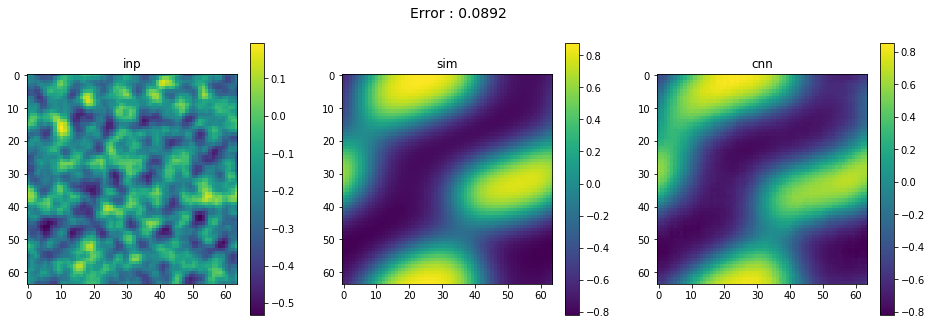

top 5 best case :


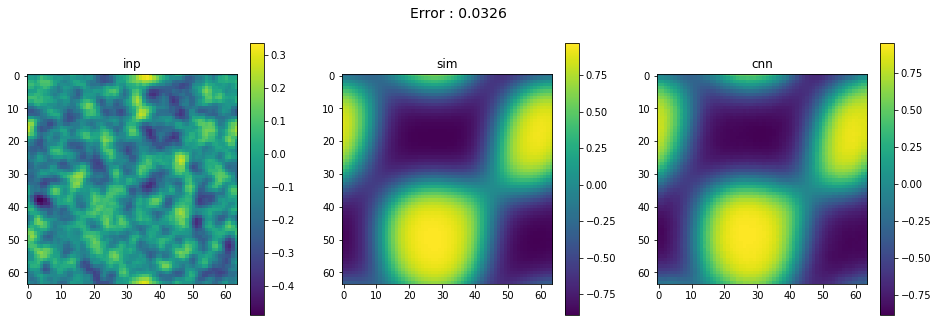

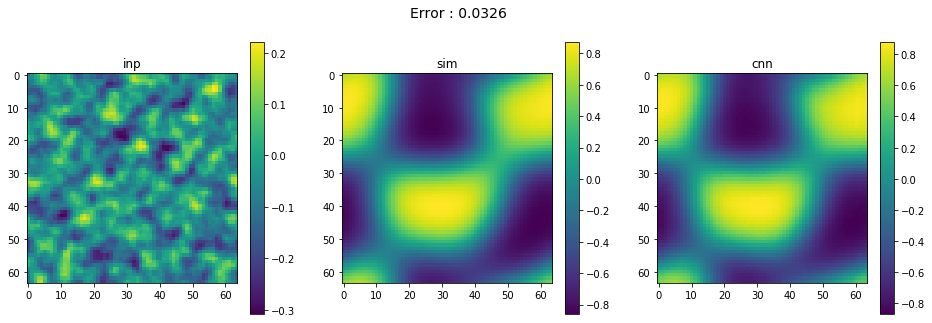

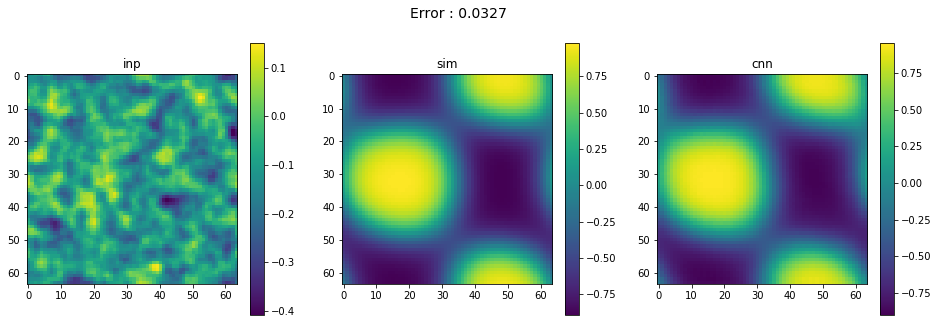

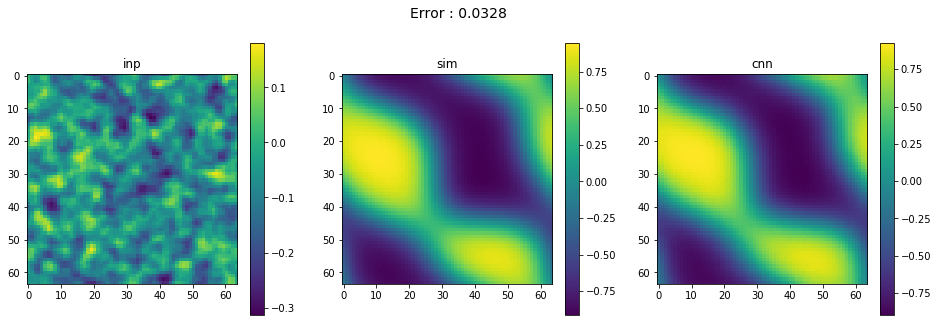

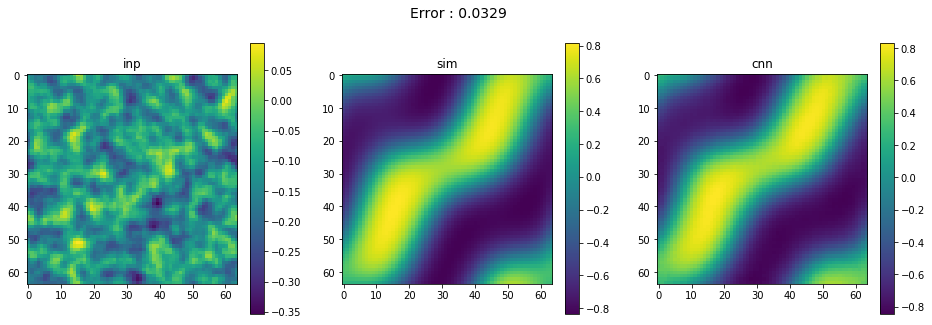

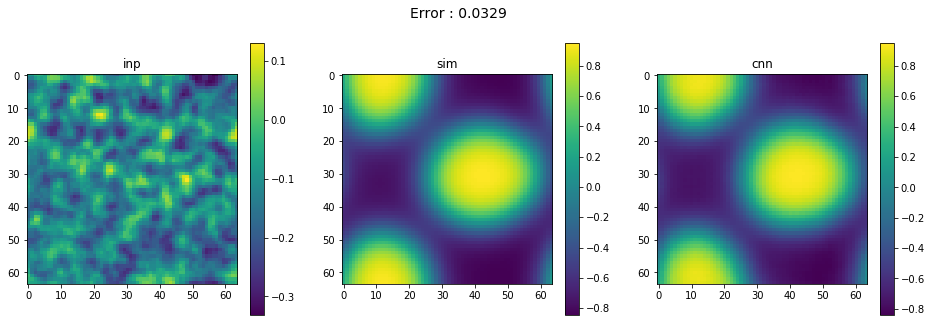

In [34]:
print("top 5 worst case :")
strt = 0
for e in sorted(err, reverse=True)[strt:strt+6]:
    ix = err.index(e)
    draw_by_side(x_val[ix], y_val[ix], y_cnn[ix], err[ix])
    
print("top 5 best case :")
strt = 150
for e in sorted(err, reverse=False)[strt:strt+6]:
    ix = err.index(e)
    draw_by_side(x_val[ix], y_val[ix], y_cnn[ix], err[ix])

## Comparision with Unet single channel model

In [8]:
%%time
def init_unif(nsamples, dim_x, dim_y, seed=354875):
    np.random.seed(seed)
    means  = np.random.uniform(-0.2, 0.2, size=nsamples)
    x_data = np.random.uniform(-0.98, 0.98, size=(nsamples, dim_x, dim_y)) - means[...,None,None]
    np.clip(x_data, -0.95, 0.95, out=x_data)
    return x_data


def init_norm(nsamples, dim_x, dim_y, seed=354875):
    np.random.seed(seed)
    means  = np.random.uniform(-0.15, 0.15, size=nsamples)
    np.random.seed(seed)
    scales  = np.random.uniform(0.3, 0.6, size=nsamples)
    
    x_data = [np.random.normal(loc=m, scale=s, size = (1, dim_x, dim_y)) for m,s in zip(means, scales)]
    x_data = np.concatenate(x_data, axis=0)
    
    np.clip(x_data, -0.95, 0.95, out=x_data)
    
    return x_data

x_val, y_val = data_generator(nsamples=512, 
                              dim_x=64, 
                                init_steps=1, 
                                delta_sim_steps = 2500,
                                dx = 0.25, 
                                dt = 0.01,
                                gamma=1.0, 
                                seed =38946235,
                                device = torch.device("cuda:0"))


# x_val, y_val = data_generator(nsamples=512, 
#                               dim_x=64, 
#                                 init_steps=10, 
#                                 delta_sim_steps = 2000,
#                                 dx = 0.25, 
#                                 dt = 0.01,
#                                 gamma=1.0, 
#                                 seed =38946235,
#                                 device = torch.device("cuda:0"))

CPU times: user 4.07 s, sys: 1.92 s, total: 5.99 s
Wall time: 5.39 s


In [23]:
fname ="out/unet/ch_unet_id_14-04-2020-02-26_run_leg_1_data_30_longrun/unet_epoch_49.pt"
# fname = "out/unet/ch_unet_id_14-04-2020-10-54_run_leg_1_data_30_longrun2000/unet_epoch_49.pt"

In [24]:
from chnet.unet import UNet
model = UNet(in_channels=1, 
             out_channels=1, 
             init_features=32).double().to(torch.device("cuda:0"))
model.load_state_dict(torch.load(fname))

transformer_x = lambda x: np.moveaxis(x[...,None], 3, 1)
x_cuda = torch.tensor(transformer_x(x_val)).double().cuda()


model.eval()
y_cnn = np.squeeze(model(x_cuda).detach().cpu().numpy())

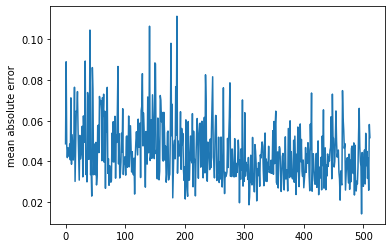

Mean Error on Validation Set: 0.0446
0.06205536763577391
0.04461243385549668


In [25]:
err = []
for ix in range(len(y_cnn)):
    err.append(maerror(y_cnn[ix], y_val[ix]))

plt.plot(np.arange(len(y_cnn)), err)
plt.ylabel("mean absolute error")
plt.show()

print("Mean Error on Validation Set: {:1.4f}".format(np.mean(err)))
print(rmserror(y_cnn, y_val))
print(maerror(y_cnn, y_val))

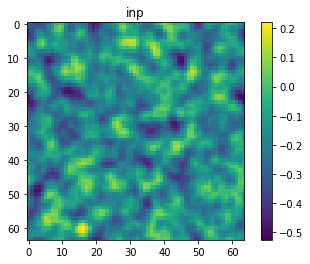

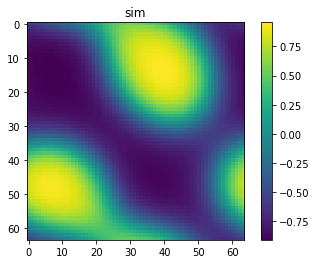

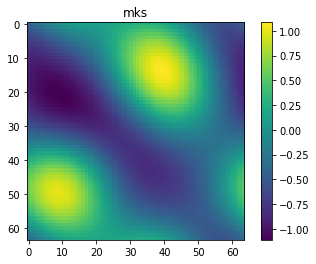

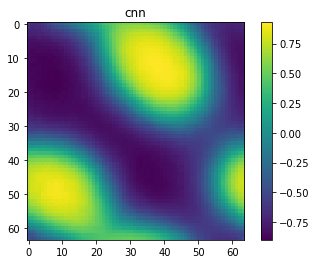

In [28]:
draw_im(x_val[0], "inp")
draw_im(y_val[0], "sim")
draw_im(y_mks[0], "mks")
draw_im(y_cnn[0], "cnn")

top 5 worst case :


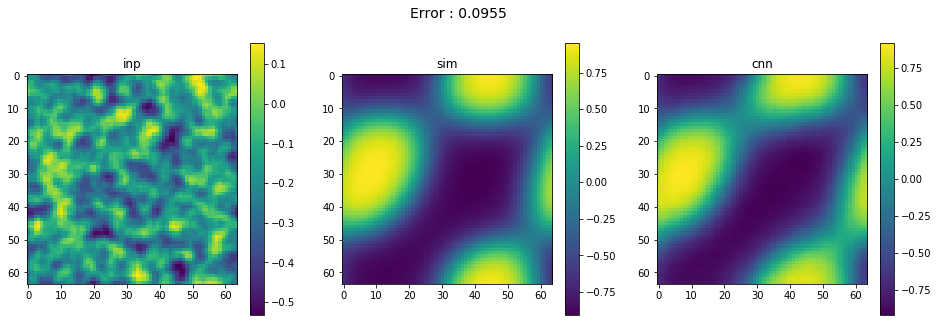

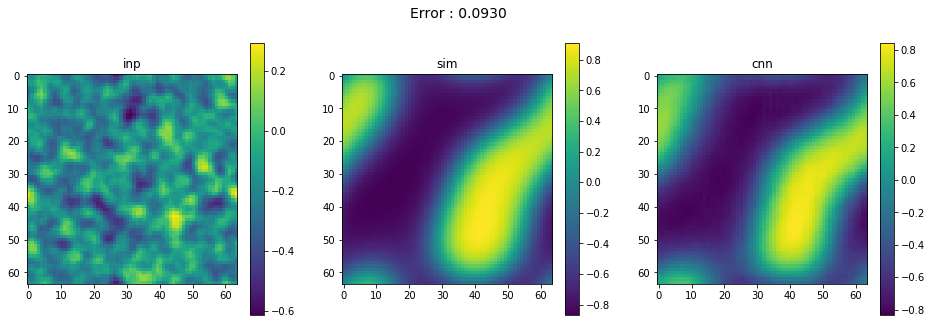

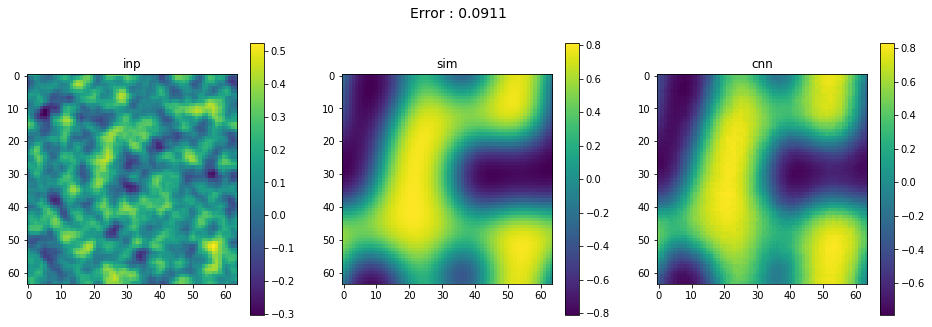

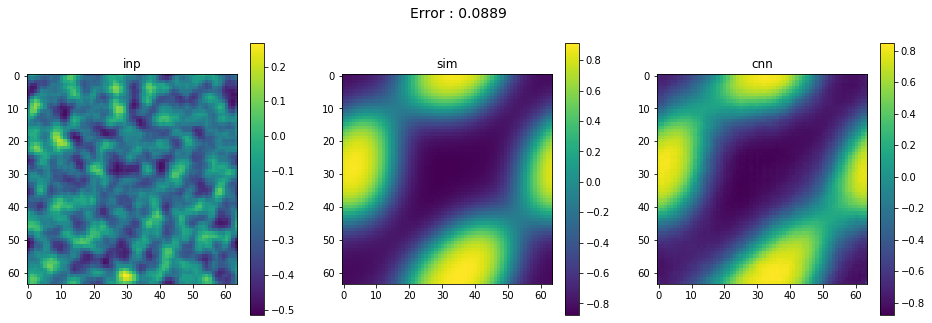

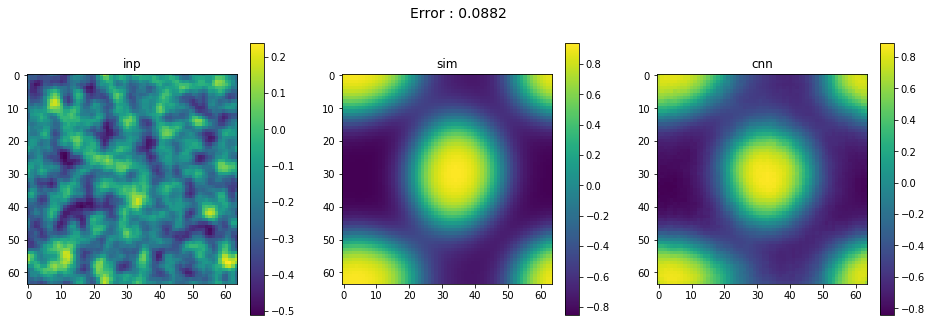

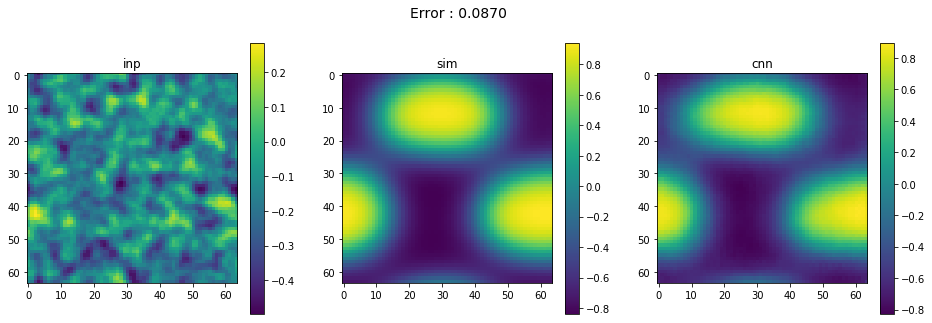

top 5 best case :


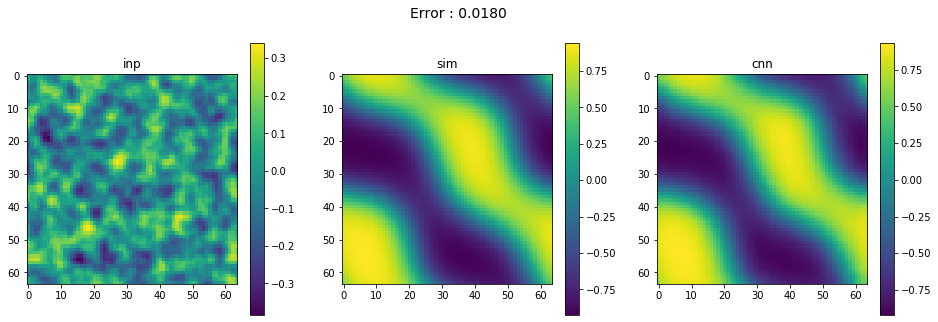

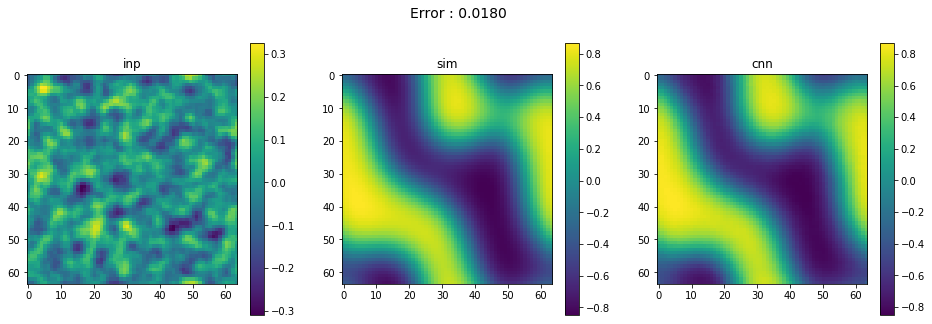

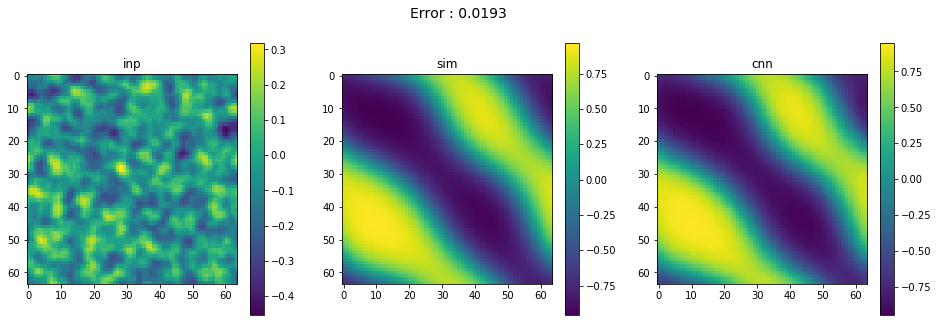

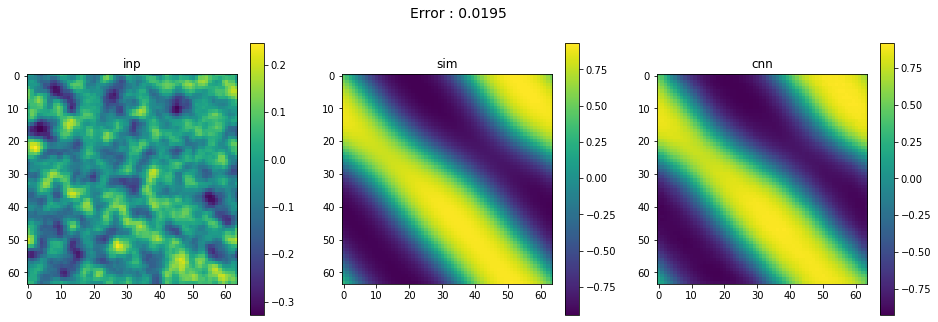

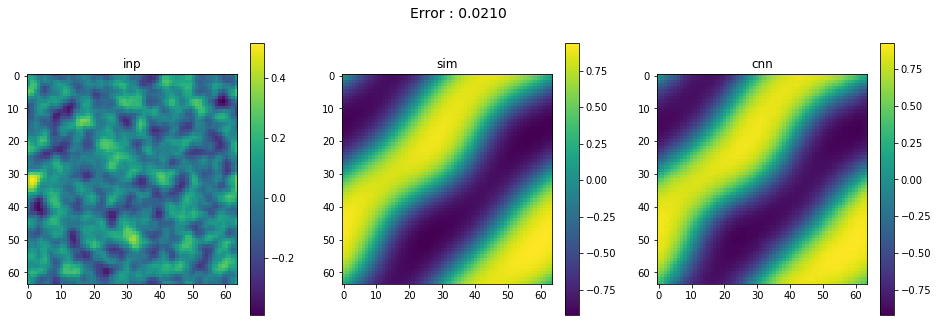

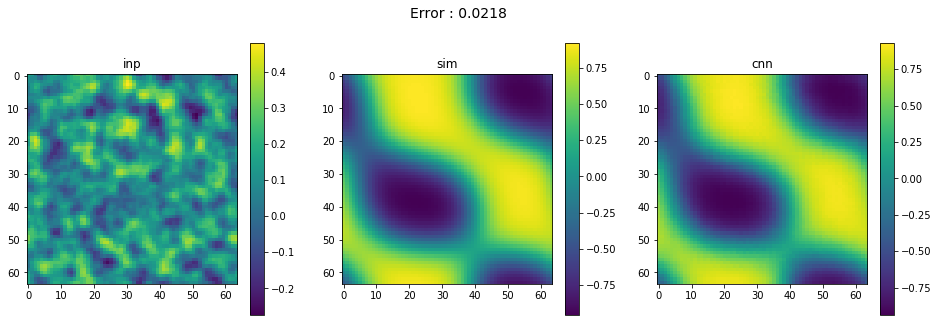

In [12]:
print("top 5 worst case :")
strt = 0
for e in sorted(err, reverse=True)[strt:strt+6]:
    ix = err.index(e)
    draw_by_side(x_val[ix], y_val[ix], y_cnn[ix], err[ix])
    
print("top 5 best case :")
strt = 0
for e in sorted(err, reverse=False)[strt:strt+6]:
    ix = err.index(e)
    draw_by_side(x_val[ix], y_val[ix], y_cnn[ix], err[ix])

In [104]:
def init_unif(nsamples, dim_x, dim_y, seed=354875):
    np.random.seed(seed)
    return np.random.uniform(-0.65, 0.75, size=(nsamples, dim_x, dim_y))-0.1


def init_norm(nsamples, dim_x, dim_y, seed=354875):
    np.random.seed(seed)
    means  = np.random.uniform(-0.3, 0.05, size=nsamples)
    scales  = np.random.uniform(0.1, 0.5, size=nsamples)
    
    x_data = [np.random.normal(loc=m, scale=s, size = (1, dim_x, dim_y)) for m,s in zip(means, scales)]
    x_data = np.concatenate(x_data, axis=0)
    
    np.clip(x_data, -0.95, 0.95, out=x_data)
    
    return x_data


@curry
def data_generator(nsamples=128, 
                   dim_x=64, 
                   init_steps=100, 
                   delta_sim_steps = 500,
                   dx = 0.25, 
                   dt = 0.01,
                   gamma=1.0, 
                   seed = None,
                   device = torch.device("cuda:0")):
    
    init_data1 = init_unif(nsamples//2, dim_x, dim_x, seed=seed)
    init_data2 = init_norm(nsamples//2, dim_x, dim_x, seed=seed)
    init_data = np.concatenate([init_data1, init_data2], axis=0)
    
    x_data = ch.ch_run_torch(init_data, dt=dt, gamma=gamma, 
                             dx=dx, sim_step=init_steps, device=device)
    y_data = ch.ch_run_torch(x_data, dt=dt, gamma=gamma, 
                             dx=dx, sim_step=delta_sim_steps, device=device)
    return x_data, y_data

In [48]:
x_val, y_val = data_generator(nsamples=512, 
                              dim_x=64, 
                                init_steps=10, 
                                delta_sim_steps = 2000,
                                dx = 0.25, 
                                dt = 0.01,
                                gamma=1.0, 
                                seed =38946235,
                                device = torch.device("cuda:0"))

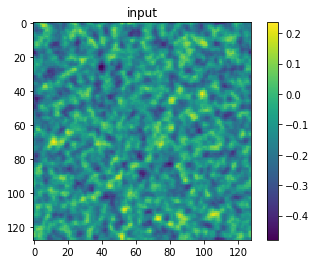

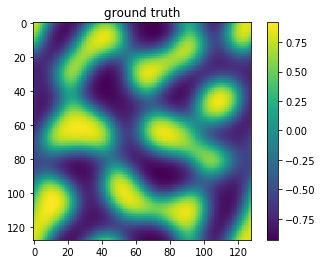

In [113]:
draw_im(x_val[-2], "input")
draw_im(y_val[-2], "ground truth")

In [114]:
fname = "out/unet/ch_unet_id_14-04-2020-01-19_run_leg_7_data_30_longrun/unet_epoch_49.pt"

In [115]:
device = torch.device("cuda:0")

leg: 7, err: 0.4905935063135962


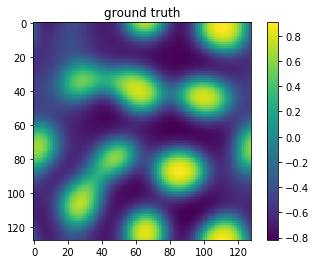

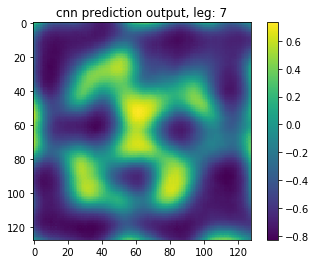

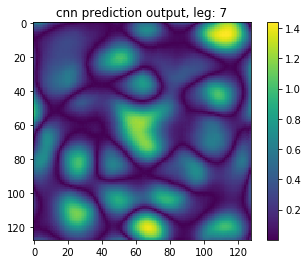

In [116]:
from chnet.unet import UNet
# n_states = 1
# transformer_x = lambda x: np.moveaxis(x[...,None], 3, 1)

domain = (-1.01, 1.01)
basis = LegendreBasis(7, domain)
transformer_x = lambda x: np.moveaxis(basis.discretize(x), 3, 1)


model = UNet(in_channels=n_states, 
             out_channels=1, 
             
             init_features=32).double()
model.load_state_dict(torch.load(fname, 
                                 map_location=device))


x_cuda = torch.tensor(transformer_x(x_val)).double()


model.eval()
y_cnn = np.squeeze(model(x_cuda).detach().cpu().numpy())


ix = -1
print("leg: {}, err: {}".format(n_states, rmserror(y_cnn, y_val)))

draw_im(y_val[ix], "ground truth")
draw_im(y_cnn[ix], "cnn prediction output, leg: {}".format(n_states))
draw_im(np.fabs(y_cnn[ix]-y_val[ix]), "cnn prediction output, leg: {}".format(n_states))

leg: 1, err: 0.2268375348020144


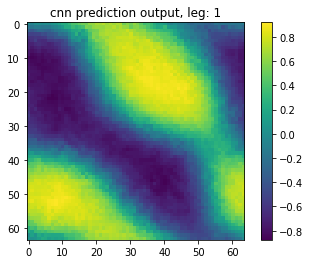

leg: 3, err: 0.246


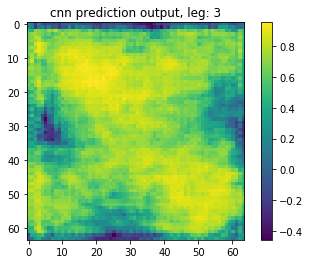

leg: 5, err: 0.270


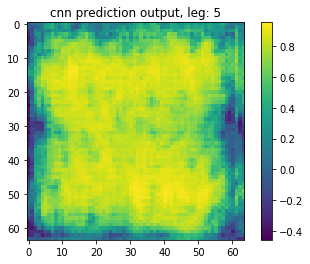

leg: 9, err: 0.383


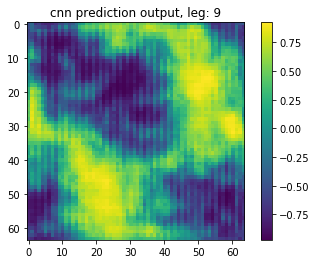

leg: 11, err: 0.365


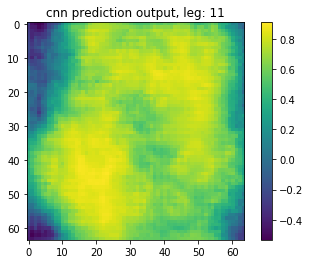

In [41]:
from chnet.unet import UNet
n_states = 1
transformer_x = lambda x: np.moveaxis(x[...,None], 3, 1)


model = UNet(in_channels=n_states, 
             out_channels=1, 
             
             init_features=32).double().to(torch.device("cuda:0"))
model.load_state_dict(torch.load("out/unet/ch_unet_id_12-04-2020-15-39_run_plain/unet_epoch_15.pt"))


x_cuda = torch.tensor(transformer_x(x_val)).double().cuda()


model.eval()
y_cnn = np.squeeze(model(x_cuda).detach().cpu().numpy())

print("leg: {}, err: {}".format(n_states, rmserror(y_cnn, y_val)))
draw_im(y_cnn[0], "cnn prediction output, leg: {}".format(n_states))



for n_states in [3, 5, 9, 11]:
    domain = (-1.01, 1.01)
    basis = LegendreBasis(n_states, domain)
    transformer_x = lambda x: np.moveaxis(basis.discretize(x), 3, 1)
    model = UNet(in_channels=n_states, 
                 out_channels=1, 
                 init_features=32).double().to(torch.device("cuda:0"))
    model.load_state_dict(torch.load("out/unet/ch_unet_id_12-04-2020-01-25_run_legendre_n_state_{}/unet_epoch_15.pt".format(n_states)))


    x_cuda = torch.tensor(transformer_x(x_val)).double().cuda()


    model.eval()
    y_cnn = np.squeeze(model(x_cuda).detach().cpu().numpy())

    print("leg: {}, err: {:1.3f}".format(n_states, rmserror(y_cnn, y_val)))
    
    draw_im(y_cnn[-2], "cnn prediction output, leg: {}".format(n_states))

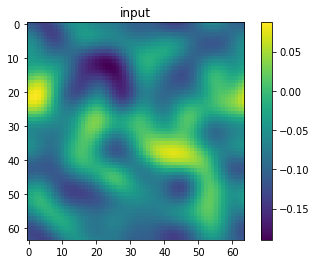

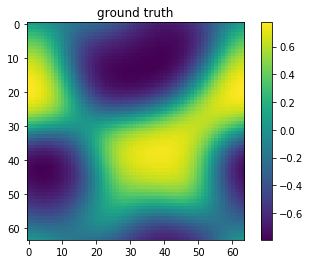

data size: 1, err: 0.3782


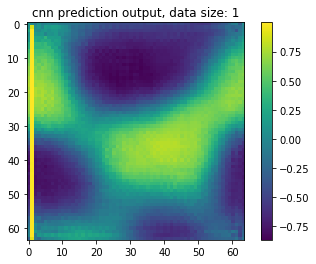

data size: 5, err: 0.2618


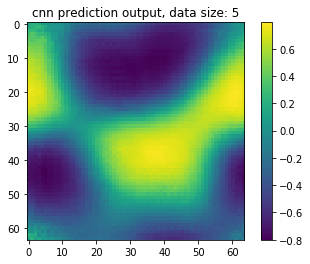

data size: 10, err: 0.1776


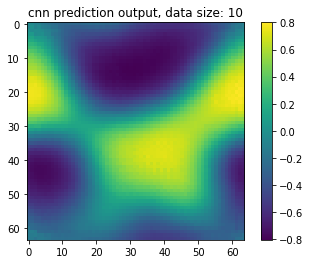

data size: 20, err: 0.1858


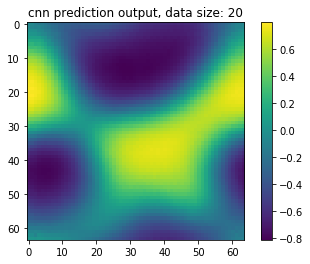

In [61]:
from chnet.unet import UNet
for n_data in [1, 5, 10, 20]:
    domain = (-1.01, 1.01)
    basis = LegendreBasis(7, domain)
    transformer_x = lambda x: np.moveaxis(basis.discretize(x), 3, 1)


    model = UNet(in_channels=7, 
                 out_channels=1, 
                 init_features=init_features).double().to(torch.device("cuda:0"))
    
    model.load_state_dict(torch.load("out/unet/ch_unet_id_13-04-2020-14-16_run_leg_7_data_{}/unet_epoch_15.pt".format(n_data)))


    x_cuda = torch.tensor(transformer_x(x_val)).double().cuda()


    model.eval()
    y_cnn = np.squeeze(model(x_cuda).detach().cpu().numpy())

    print("data size: {}, err: {:1.4f}".format(n_data, rmserror(y_cnn, y_val)))
    
    draw_im(y_cnn[0], "cnn prediction output, data size: {}".format(n_data))